In [6]:
function fftc(img)
    return ifftshift(fft(fftshift(img)))
end
function ifftc(ksp)
    return fftshift(ifft(ifftshift(ksp)))
end
# Pkg.add("MAT")
# Pkg.add("Images")
# Pkg.add("PyPlot")
using Images, MAT, PyPlot

In [7]:
# get data from http://hansenms.github.io/sunrise/sunrise2013/
HANSEN = matread("ismrm_sunrise_parallel/hansen_exercises.mat") 

Dict{ASCIIString,Any} with 9 entries:
  "smaps"        => 256x256x8 Array{Complex{Float64},3}:…
  "noise_color"  => 256x256x8 Array{Complex{Float64},3}:…
  "w_spiral"     => 18176x1 Array{Float64,2}:…
  "sp"           => 256x256 Array{Float64,2}:…
  "k_spiral"     => 18176x2 Array{Float64,2}:…
  "data_spiral"  => 18176x8 Array{Complex{Float64},2}:…
  "data"         => 256x256x8 Array{Complex{Float64},3}:…
  "noise_spiral" => 18176x8 Array{Complex{Float64},2}:…
  "reg_img"      => 256x256 Array{Float64,2}:…

In [8]:
# putting each keys in Dictionary as a local variable
for (k, v) in HANSEN
    k=symbol(k) 
    @eval (($k) = ($v))
end

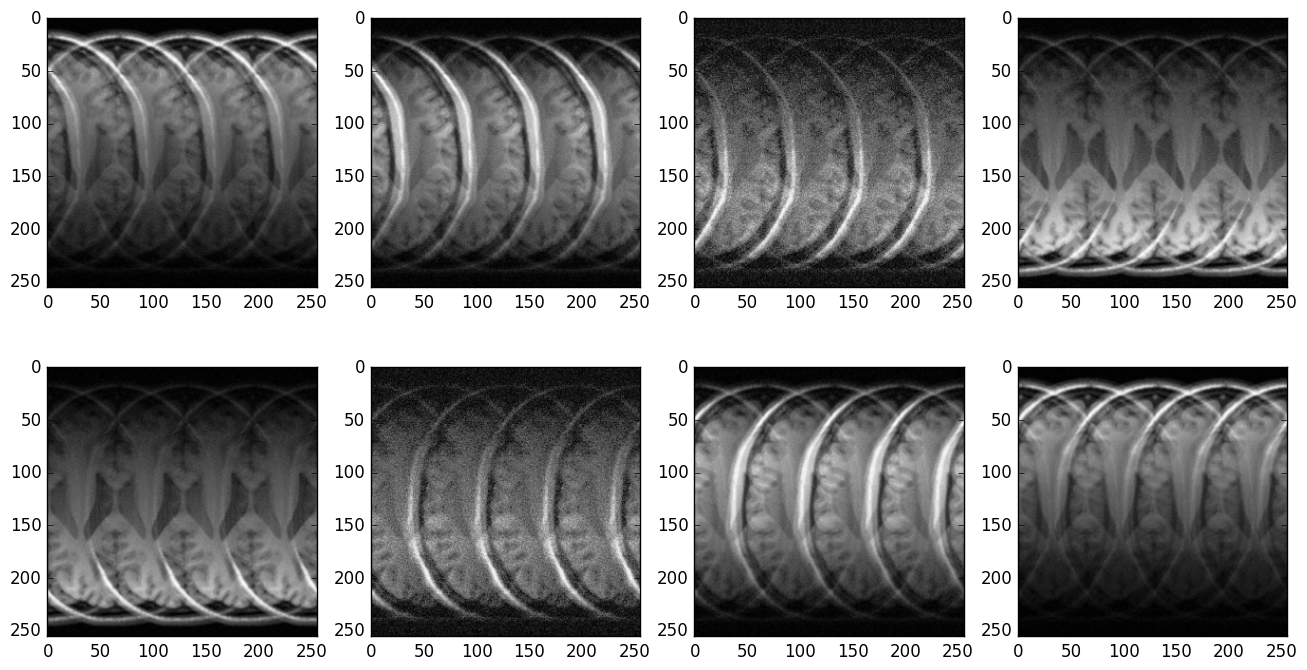

In [9]:
# Visualize coil images
fig = PyPlot.figure("Coil image", figsize=(16,8))
for i in range(1,4)
    subplot(2, 4, i )
    imshow(abs(ifftc(data[:,:,i+0])), cmap= "Greys_r")
    subplot(2, 4, i + 4)
    imshow(abs(ifftc(data[:,:,i+4])), cmap= "Greys_r")
end

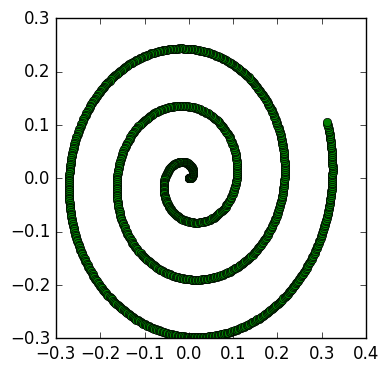

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x318adc588>

In [10]:
# Visualize trajectory
figure(figsize=(4,4))
t = k_spiral'[1:1:2000]
plot(t[1:2:2000], t[2:2:2000], "go-")

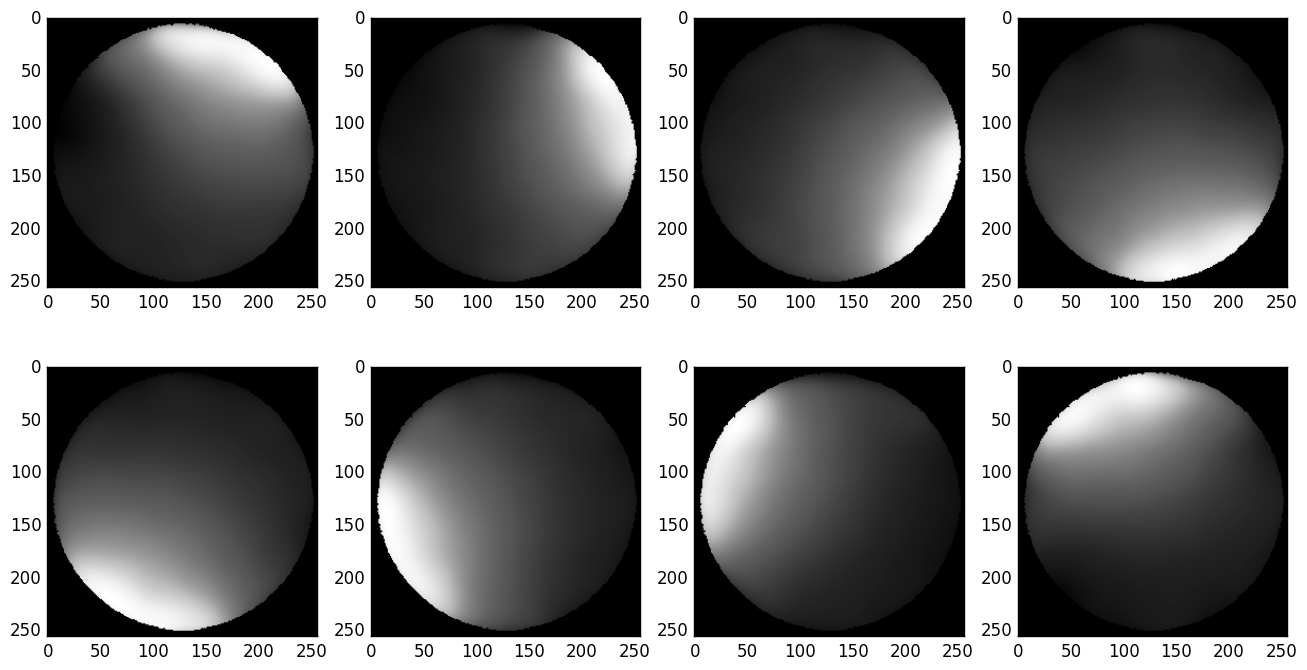

In [11]:
x, y, ncoils = size(smaps)
fig = figure(figsize=(16,8))
for i in range(1, 8)
     subplot(2,4,i) 
    imshow(abs(smaps[:,:,i]), cmap= "Greys_r")
end

In [12]:
function NuFFT(image, coils, k_traj, w, n, osf, wg)
    # padding with zeros 
    pw = pad_width = round(Int64, n*(osf-1)/2 )
    image = padarray(image, [pw,pw,0], Complex(0.0))
    
    # kernel computation 
    kw = wg / osf
    kosf = floor(0.91 / (osf*1e-3))
    kwidth = osf*kw / 2
    beta = pi*sqrt((kw*(osf-0.5))^2-0.8) 

    # compute kernel
    om = collect(0:kosf*kwidth)/(kosf*kwidth)
    p = besseli(0, beta*sqrt(1-om.*om))
    p /= p[1]
    p[end] = 0

    # deapodize
    x = collect(Complex{Float64}, -osf*n/2:osf*n/2-1)/n
    sqa = sqrt(pi^2*kw^2*x.^2-beta^2)
    dax = sin(sqa)./(sqa)
    # normalize by DC value
    dax /= dax[round(Int64, osf*n/2)]
    
    # make it a 2D array
    da = dax*dax' # outer matrix mulplication of dax
    image = image./da
   (A,B) = size(k_traj)
    m = zeros(Complex{Float64}, A,coils)
    
    # convert k-space trajectory to matrix indices
    nx = n*osf/2 + 1 + osf*n*k_traj[:,1]
    ny = n*osf/2 + 1 + osf*n*k_traj[:,2]

    # Do the NuFFT for each coil
    for j in collect(1:coils)
        kspace = fftc(image[:,:,j])
        
        # loop over samples in kernel at grid spacing
        for lx in collect(-kwidth:kwidth)
            for ly in collect(-kwidth:kwidth)
                
                # find nearest samples
                nxt = round(Int64, nx+lx)
                nyt = round(Int64, ny+ly)
                
                # seperable kernel value
                kkr = min(round(Int64, kosf*sqrt(abs(nx-nxt).^2+abs(ny-nyt).^2)+1), floor(kosf*kwidth)+1)
                kwr = p[round(Int64, kkr)]
                
                # if data falls outside matrix, put it at the edge, zero out below
                nxt = max(nxt,1)
                nxt = min(nxt,osf*n)
                nyt = max(nyt,1)
                nyt = min(nyt,osf*n)
                vector = Array(Complex{Float64}, length(nxt), 1)
                for i in collect(1:length(nxt))
                    vector[i] = kspace[nxt[i],nyt[i]]
                end
                m[:,j] += vector .* kwr
            end
        end
    end
    return m.*sqrt(w)
end

NuFFT (generic function with 1 method)

In [13]:
function NuFFT_adj(data, coils, k_traj, w, n, osf, wg)
    # width of the kernel on the original grid
    kw = wg / osf
    
    # preweight
    dw = data .* sqrt(w)
    
    # compute kernel, assume e1 is 0.001, assuming nearest neighbor
    kosf = floor(0.91/(osf*1e-3))
    
    # half width in oversampled grid units
    kwidth = osf * kw / 2
    
    # beta from the Beatty paper
    beta = pi * sqrt((kw*(osf-0.5))^2 - 0.8)
    
    # compute kernel
    om = collect(Complex{Float64}, 0:kosf*kwidth)/(kosf*kwidth)
    p = besseli(0,beta*sqrt(1-om.*om))
    p = p./p[1]
    p[end] = 0
    
    # last sample is zero so we can use min() below for samples bigger than kwidth
    
    # convert k-space trajectory to matrix indices
    nx = n*osf/2 + 1 + osf*n*k_traj[:,1]
    ny = n*osf/2 + 1 + osf*n*k_traj[:,2]
    
    im = zeros(Complex{Float64}, osf*n, osf*n, coils)
    
    for j in collect(1:coils)
        ksp = zeros(Complex{Float64}, size(im[:,:,j]))
        for lx in collect(-kwidth:kwidth)
            for ly in collect(-kwidth:kwidth)
                
                # find nearest samples
                nxt = round(Int64, nx+lx)
                nyt = round(Int64, ny+ly)
                
                # seperable kernel value
                kkr = min(round(Int64, kosf*sqrt(abs(nx-nxt).^2+abs(ny-nyt).^2)+1), floor(kosf*kwidth)+1)
                kwr = p[round(Int64,kkr)]
                 nxt = max(nxt,1)
                 nxt = min(nxt,osf*n)
                 nyt = max(nyt,1)
                 nyt = min(nyt,osf*n)
                
                # accumulate gridded data
                ksp += sparse(nxt,nyt,dw[:,j].*conj(kwr),osf*n,osf*n)
            end
        end
        # zero out data at edges, which is probably due to data outside mtx

        ksp[:,1] = ksp[:,end] = ksp[1,:] = ksp[end,:] = 0  

        # do the FFT and deapodize
        
        im[:,:,j] = ifftc(ksp)
    end

    # deapodize
    x = collect(Complex{Float64},-osf*n/2:osf*n/2-1)/ n
    sqa = sqrt(pi*pi * kw*kw * x.*x - beta^2)
    dax = sin(sqa) ./ sqa
    dax /= dax[round(Int64,osf*n/2)]
    da = dax*dax' # outer matrix multiplication of dax
    im = im./da
    
    # trim the images
    q = round(Int64, (osf-1)*n/2)
    return im[q+1:n+q, q+1:n+q,:] 
end

NuFFT_adj (generic function with 1 method)

In [14]:
N = [Int(x) for x in size(smaps)[1:2]]
osf = 2
wg = 5
K = N*osf
n = N[1]
scale = sqrt(prod(K))
coils = size(smaps)[3]

@assert all(N == [256, 256])
@assert all(K == [512, 512])
@assert n == 256
@assert coils == 8
@assert scale == 512

In [15]:
function dotf(a, b)
    return sum(a.*b)
end

function Eforward(image, csm, k_traj, weights, n, coils, wg, osf, scale)
    (x, y) = size(image)
    return NuFFT(reshape(image, x,y, 1) .* csm, coils, k_traj, weights, n, osf, wg) / scale
end
function Etransp(data, csm, k_traj, weights, n, coils, wg, osf, scale)
    matrix = conj(csm) .* NuFFT_adj( data, coils, k_traj, weights, n, osf, wg)
    return squeeze(sum(matrix, ndims(matrix)) * scale, ndims(matrix))
end

E_forward(x) = Eforward(x, smaps, k_spiral, w_spiral, n, coils, wg, osf, scale)
E_transp(y)  = Etransp(y, smaps, k_spiral, w_spiral, n, coils, wg, osf, scale)

E_transp (generic function with 1 method)

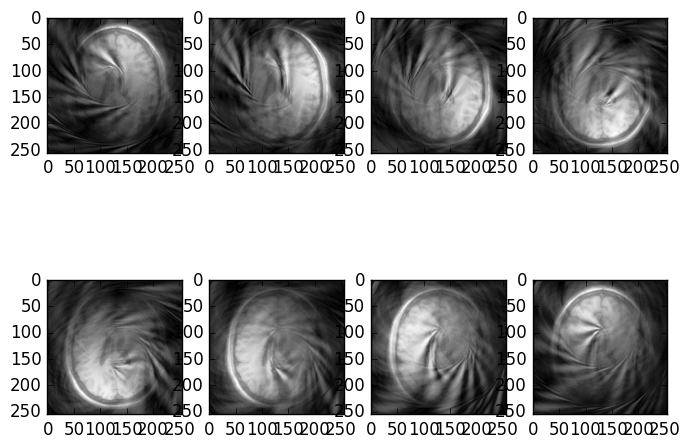

In [16]:
im = NuFFT_adj(data_spiral, coils, k_spiral, w_spiral, n, osf, wg )
for i in collect(1:8)
    subplot(2,4,i) 
    imshow(abs(im[:,:,i]), cmap="Greys_r");
end

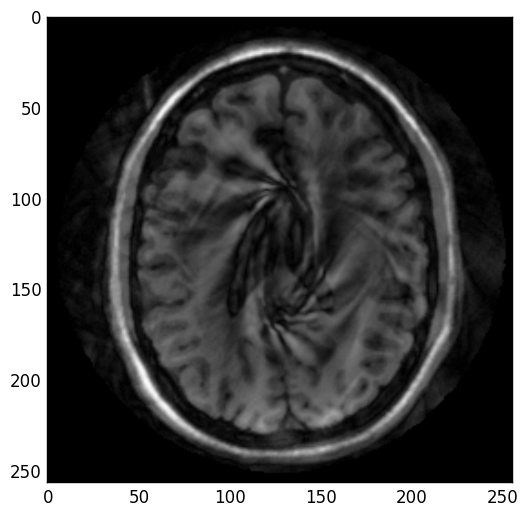

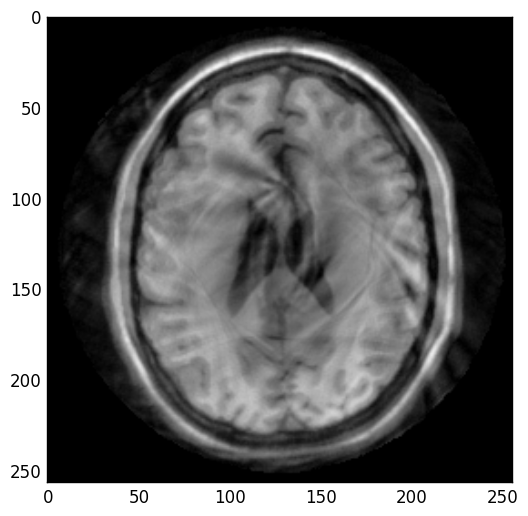

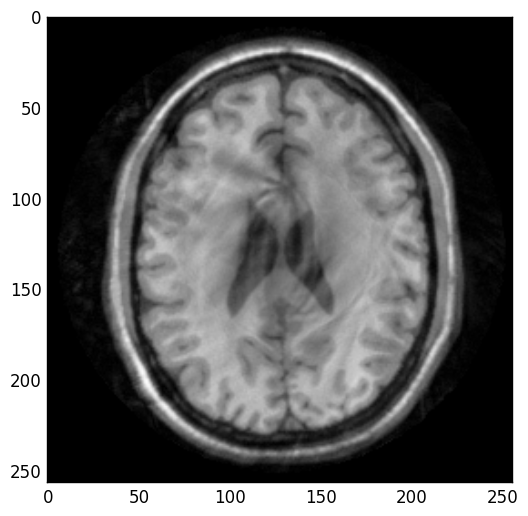

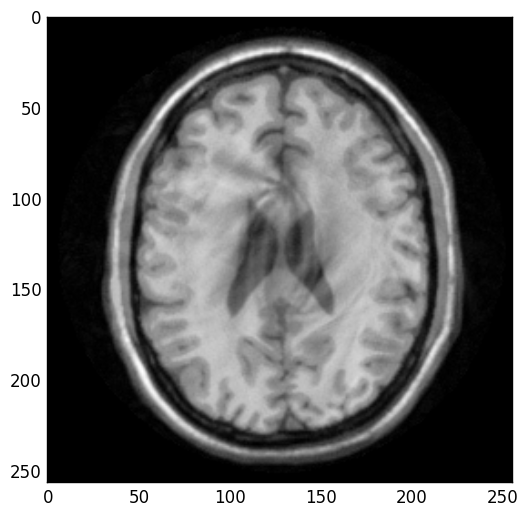

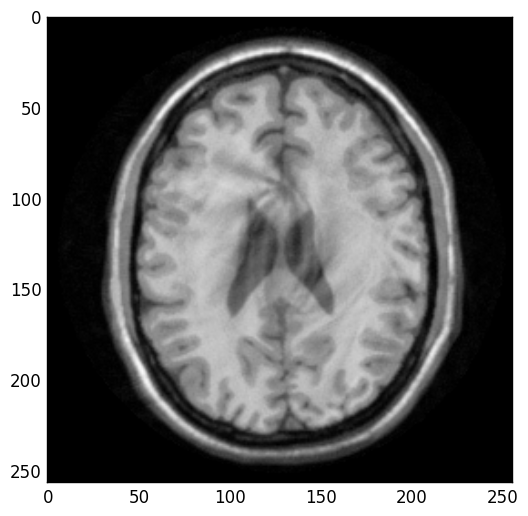

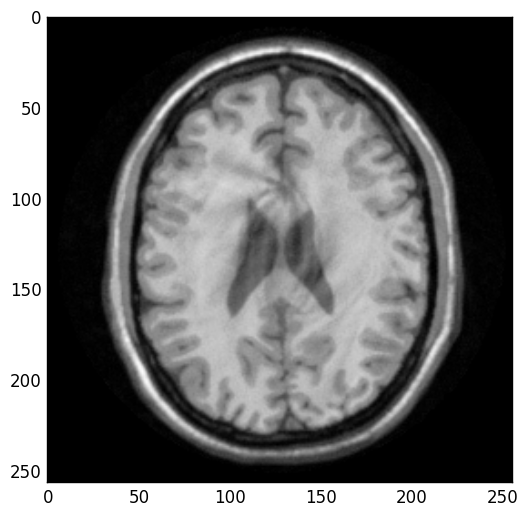

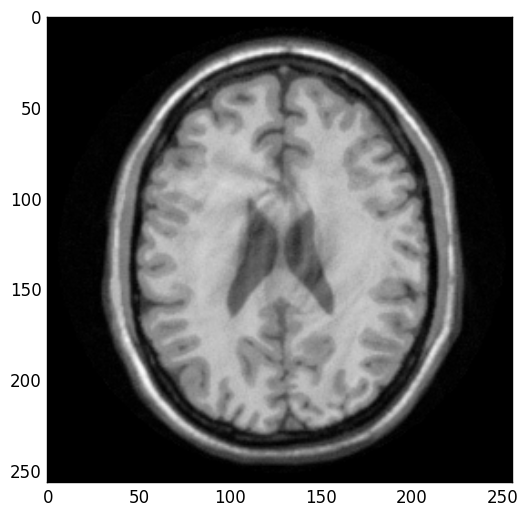

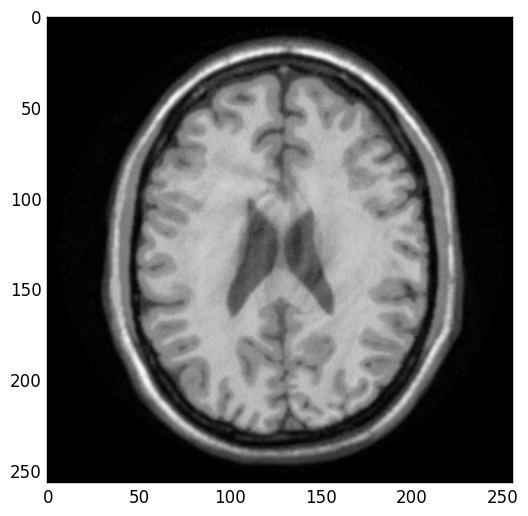

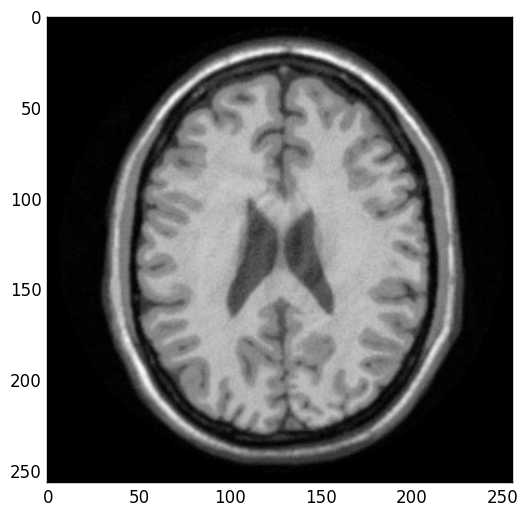

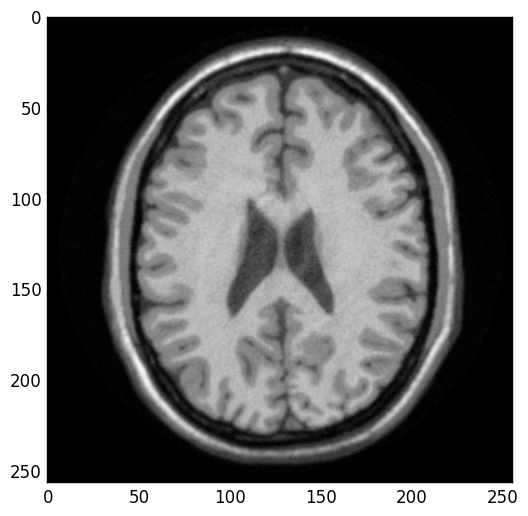

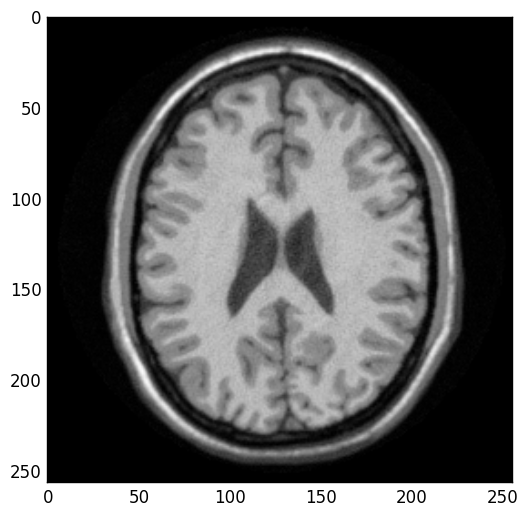

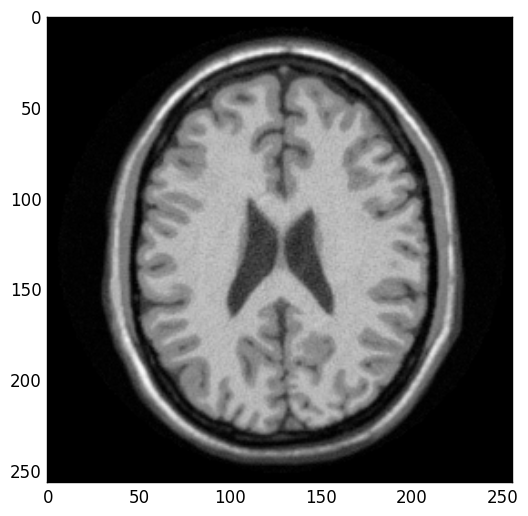

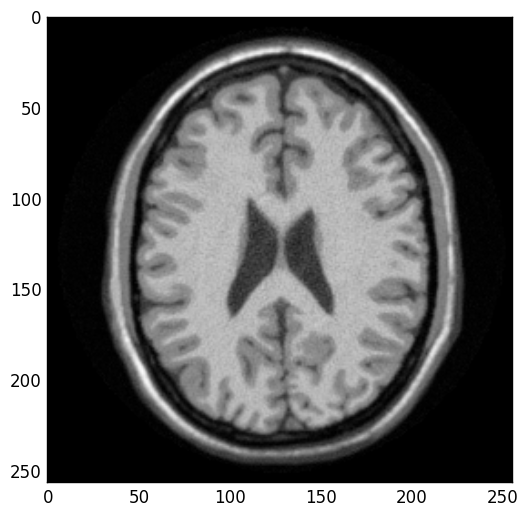

In [18]:
At(v) = E_transp(v)
AtA(v) = E_transp(E_forward(v))
coildata = data_spiral .* sqrt(w_spiral)

# AtA*x = At*b
b = At(coildata)
x = zeros(Complex{Float64}, size(smaps[:,:,1]))
r = b - AtA(x)
p = copy(r)
for i in collect(1:13)
    rsold = dotf(r, r)
    AtAp = AtA(p)
    alpha = rsold ./ dotf(p, AtAp)
    x += alpha .* p
    r -= alpha .* AtAp   
    rsnew = dotf(r,r)
    beta = rsnew ./ rsold
    p = r + beta .* p
    figure(figsize=(6,6))
    imshow(abs(x), cmap="Greys_r")
end